In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%cd "/Users/morteza/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/Dokumente/2. WiIng/3. Semester WS25-26/EE"

/Users/morteza/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/Dokumente/2. WiIng/3. Semester WS25-26/EE


In [21]:
# historische Daten aus our_world_in_data
# https://ourworldindata.org/electric-car-sales 
hist_N_df = pd.read_excel("energy-economics-ws25-26-ev-china/Our_world_in_data.xlsx", sheet_name="N_hist_total", header=0, index_col=0)
hist_n_df = pd.read_excel("energy-economics-ws25-26-ev-china/Our_world_in_data.xlsx", sheet_name="n_hist_yearly", header=0, index_col=0)
hist_n_df

,Electric cars sold
Year,
2010,1440
2011,5120
2012,9860
2013,15730
2014,73000
2015,211000
2016,339000
2017,580000
2018,1090000


In [11]:
def _simulate_bass(p, q, m, T=30, dt=1.0, N0=0.0):
    """Simuliert Bass (Euler diskret). Gibt t, N(t), n(t) zurück."""
    if p < 0 or q < 0 or m <= 0:
        raise ValueError("Require p >= 0, q >= 0, and m > 0.")
    if N0 < 0 or N0 > m:
        raise ValueError("Require 0 <= N0 <= m.")
    if T <= 0 or dt <= 0:
        raise ValueError("Require T > 0 and dt > 0.")

    steps = int(np.ceil(T / dt)) + 1
    t = np.linspace(0, T, steps)

    N = np.zeros_like(t)
    n = np.zeros_like(t)
    N[0] = N0

    for i in range(1, len(t)):
        adoption_rate = (p + q * (N[i-1] / m)) * (m - N[i-1])
        dN = adoption_rate * dt
        N[i] = min(m, N[i-1] + dN)   # Overshoot verhindern
        n[i] = N[i] - N[i-1]
    
    # DataFrame
    df = pd.DataFrame({
        "t": t,
        "N": N,
        "n": n
    })

    return df

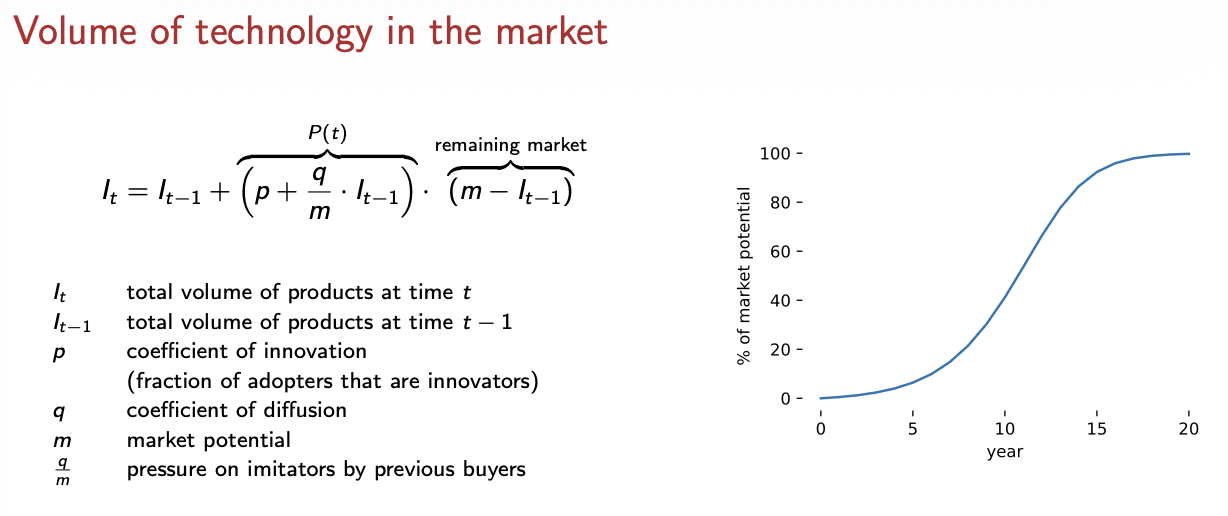

In [12]:
def bass_sensitivity(
    m,
    scenarios,
    T=30,
    dt=1.0,
    N0=0.0,
    start_year=0,
    title="Bass Diffusion Sensitivity",
    historisch=True
):
    """
    Sensitivity Analysis: mehrere (p,q)-Szenarien, zwei Plots (kumulativ & Zuwachs).
    Erwartet: _simulate_bass(...) gibt einen DataFrame mit Spalten t, N, n zurück.

    historisch = True : die historische Daten werden auch als Balken angezeigt
    """

    if not isinstance(scenarios, (list, tuple)) or len(scenarios) == 0:
        raise ValueError("scenarios must be a non-empty list of dicts with keys 'p' and 'q'.")

    # start_year robust (0, int, "2010", etc.)
    if start_year in (None, ""):
        start_year = 0
    if isinstance(start_year, str):
        start_year = int(start_year)

    results = []
    for s in scenarios:
        if "p" not in s or "q" not in s:
            raise ValueError("Each scenario dict must contain keys 'p' and 'q'.")
        p, q = float(s["p"]), float(s["q"])
        label = s.get("label", f"p={p:.4g}, q={q:.4g}")

        df = _simulate_bass(p=p, q=q, m=m, T=T, dt=dt, N0=N0)  # <-- DataFrame
        results.append((label, p, q, df))

    # x-Achse aus erstem DF (alle haben gleiche t-Gitter)
    t = results[0][3]["t"].to_numpy()
    x = t + start_year if start_year else t
    xlab = "Year" if start_year else "Time"

    fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)
    ax1, ax2 = axes


    # Historische Balken (oben: N)
    # Bars etwas transparent, damit Linien sichtbar bleiben
    if historisch == True:
        ax1.bar(hist_N_df.index, hist_N_df["Electric car stocks"].divide(1e6), width=0.8, alpha=0.35, label="Historical N", color="red")

    # oben: kumulativ
    for (label, p, q, df) in results:
        ax1.plot(x, df["N"].divide(1e6).to_numpy(), label=label)
    ax1.set_title(f"{title} — Cumulative Adoption")
    ax1.set_ylabel("Cumulative adopters N(t) in Millions")
    ax1.grid(True)
    ax1.legend()



    # Historische Balken (unten: n)
    if historisch == True:
        ax2.bar(hist_n_df.index, hist_n_df["Electric cars sold"].divide(1e6), width=0.8, alpha=0.35, label="Historical n", color="red")

    # unten: Zuwachs pro Zeitschritt
    step_name = "year" if dt == 1.0 else "step"
    for (label, p, q, df) in results:
        ax2.plot(x, df["n"].divide(1e6).to_numpy(), label=label)
    ax2.set_title(f"{title} — New Adopters per {step_name}")
    ax2.set_xlabel(xlab)
    ax2.set_ylabel(f"New adopters n(t) per {step_name} (Millions)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return results

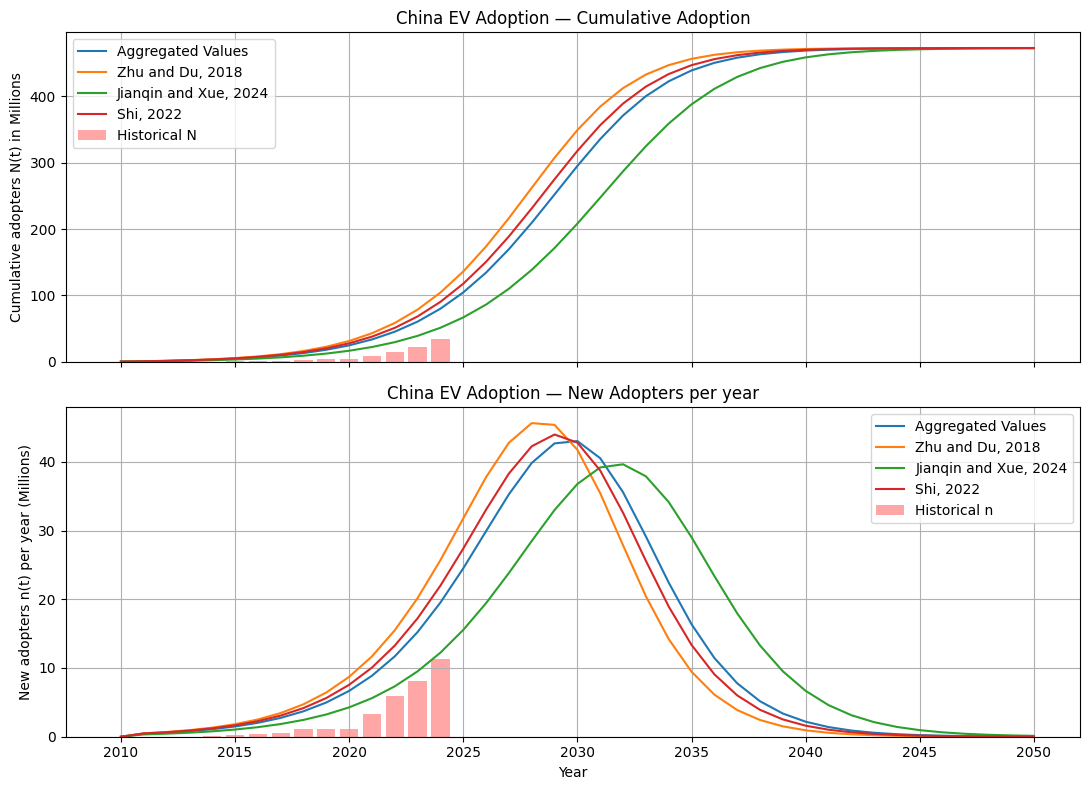

[('Aggregated Values',
  0.0009133333333333333,
  0.3636566666666667,
         t             N             n
  0    0.0  7.450000e+03  0.000000e+00
  1    1.0  4.421591e+05  4.347091e+05
  2    2.0  1.034406e+06  5.922466e+05
  3    3.0  1.840813e+06  8.064078e+05
  4    4.0  2.937958e+06  1.097144e+06
  5    5.0  4.429053e+06  1.491095e+06
  6    6.0  6.452587e+06  2.023534e+06
  7    7.0  9.193216e+06  2.740629e+06
  8    8.0  1.289502e+07  3.701806e+06
  9    9.0  1.787677e+07  4.981748e+06
  10  10.0  2.454775e+07  6.670984e+06
  11  11.0  3.342100e+07  8.873250e+06
  12  12.0  4.511750e+07  1.169650e+07
  13  13.0  6.035056e+07  1.523306e+07
  14  14.0  7.987410e+07  1.952354e+07
  15  15.0  1.043749e+08  2.450077e+07
  16  16.0  1.342924e+08  2.991757e+07
  17  17.0  1.695727e+08  3.528026e+07
  18  18.0  2.094084e+08  3.983574e+07
  19  19.0  2.520873e+08  4.267886e+07
  20  20.0  2.951047e+08  4.301737e+07
  21  21.0  3.356290e+08  4.052433e+07
  22  22.0  3.712019e+08  3.55729

In [29]:
#m = 330_000_000 # Markt Potential of Cars in China
#m = 34_000_000 / 0.11 # from Our World in Data for 2024
m = 473_000_000

p_avg = (0.001045 + 0.000695 + 0.001)/3
q_avg = (0.38637 + 0.33460 + 0.37)/3

scenarios = [
    #{"p": 0.010, "q": 0.35,         "label": "Baseline"},
    {"p": p_avg, "q": q_avg,         "label": "Aggregated Values"},
    {"p": 0.001045, "q": 0.38637,   "label": "Zhu and Du, 2018"},
    {"p": 0.000695, "q": 0.33460,   "label": "Jianqin and Xue, 2024"},
    #{"p": 0.00015, "q": 0.60,       "label": "UC_Davis_High_q"},
    {"p": 0.001, "q": 0.37,         "label": "Shi, 2022"},
]




bass_sensitivity(
    m=m,
    scenarios=scenarios,
    T=40,
    dt=1.0,
    N0=7_450,
    start_year=2010,
    title="China EV Adoption",
    historisch=True
)

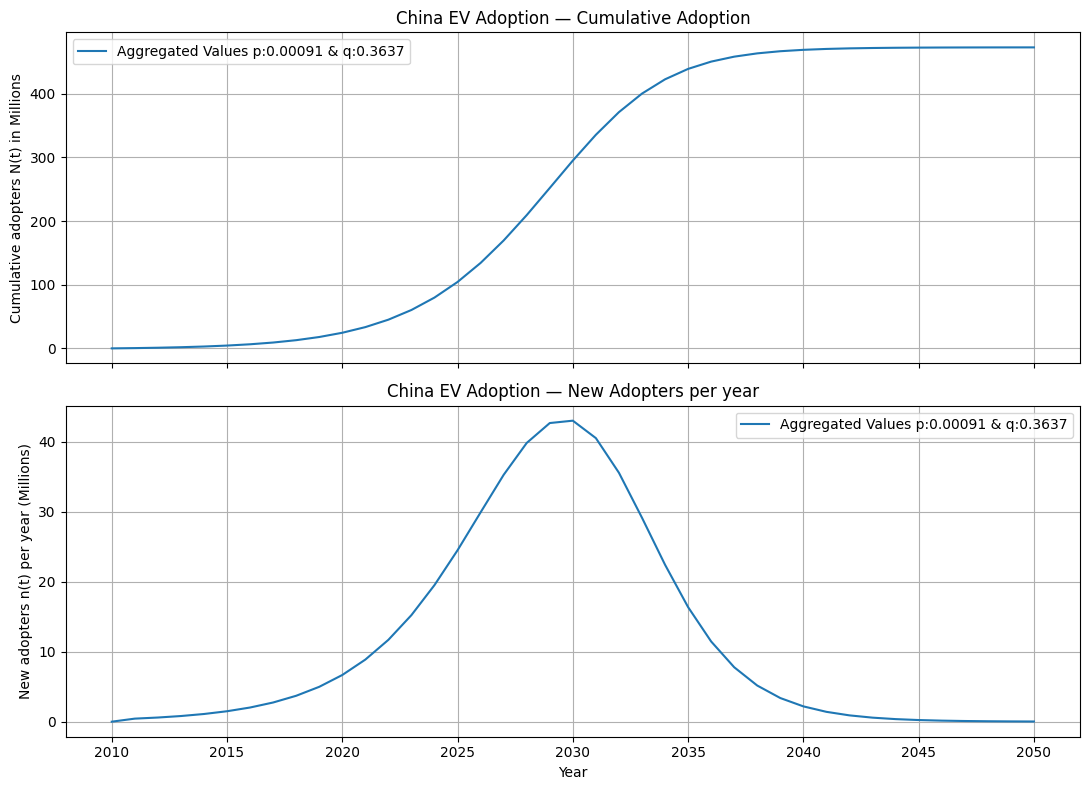

[('Aggregated Values p:0.00091 & q:0.3637',
  0.0009133333333333333,
  0.3636566666666667,
         t             N             n
  0    0.0  7.450000e+03  0.000000e+00
  1    1.0  4.421591e+05  4.347091e+05
  2    2.0  1.034406e+06  5.922466e+05
  3    3.0  1.840813e+06  8.064078e+05
  4    4.0  2.937958e+06  1.097144e+06
  5    5.0  4.429053e+06  1.491095e+06
  6    6.0  6.452587e+06  2.023534e+06
  7    7.0  9.193216e+06  2.740629e+06
  8    8.0  1.289502e+07  3.701806e+06
  9    9.0  1.787677e+07  4.981748e+06
  10  10.0  2.454775e+07  6.670984e+06
  11  11.0  3.342100e+07  8.873250e+06
  12  12.0  4.511750e+07  1.169650e+07
  13  13.0  6.035056e+07  1.523306e+07
  14  14.0  7.987410e+07  1.952354e+07
  15  15.0  1.043749e+08  2.450077e+07
  16  16.0  1.342924e+08  2.991757e+07
  17  17.0  1.695727e+08  3.528026e+07
  18  18.0  2.094084e+08  3.983574e+07
  19  19.0  2.520873e+08  4.267886e+07
  20  20.0  2.951047e+08  4.301737e+07
  21  21.0  3.356290e+08  4.052433e+07
  22  22.0  

In [30]:
scenario_avg = [
    {"p": p_avg, "q": q_avg,  "label": f"Aggregated Values p:{p_avg:.2} & q:{q_avg:.4}"},
]


bass_sensitivity(
    m=m,
    scenarios=scenario_avg,
    T=40,
    dt=1.0,
    N0=7_450,
    start_year=2010,
    title="China EV Adoption",
    historisch=False
)
